In [1]:
import numpy as np
from scipy.io import savemat
#%matplotlib qt
import matplotlib.pyplot as plt
import french

In [14]:
nT = 100
nrho = 100
rho = np.linspace(1.5, 5.8, nrho)
T = np.linspace(20, 2000, nT)
rho, T = np.meshgrid(rho, T)
%time f, s, cv, p, u, g = french.french(rho, T, model='PBE', gibbs=True)

G0 = 7.5933e+07
S0 = -3100

cv *= 1e6
g *= 1e6 
g += G0 - S0 * (T - 353.5)
u *= 1e6
p *= 1e9
rho *= 1e3
s *= 1e6

CPU times: user 6.85 s, sys: 126 ms, total: 6.97 s
Wall time: 8.47 s


In [4]:
#dP = np.diff(g, axis=0) / np.diff(p, axis=0)
#dPT = np.diff(dP, axis=0) / np.diff(T[1:], axis=0)

#dP = np.diff(g, axis=0) / np.diff(p, axis=0)
#d2P = np.diff(dP, axis=0) / np.diff(p[1:], axis=0)

#dT = np.diff(g, axis=0) / np.diff(T, axis=0)
#d2T = np.diff(dT, axis=0) / np.diff(T[1:], axis=0)

#cp = cv[1:-1] - T[1:-1] * dPT * dPT / d2P
#cp = -d2T * T[1:-1]

#fig = plt.figure(figsize=(14, 9))
#ax = plt.axes(projection='3d')
#ax.scatter(p[1:-1], T[1:-1], cp, c=cp, alpha=1)

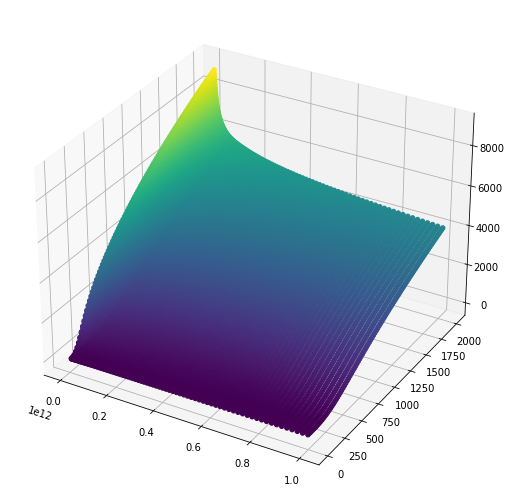

In [4]:
fig = plt.figure(figsize=(14, 9))
ax = plt.axes(projection='3d')
ax.scatter(p, T, s, c=s, alpha=1)
#print(np.min(p)/1e9)

(0.0, 50000000000.0)

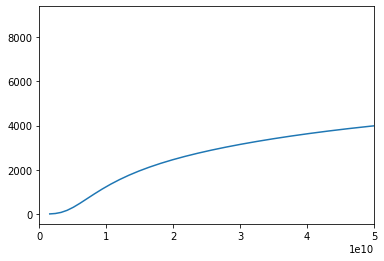

In [5]:
plt.plot(p[0], s[:,0])
plt.xlim(0, 0.05e12)

In [15]:
from scipy.interpolate import bisplrep, bisplev

k = 5

%time tck_g = bisplrep(p, T, g, kx=k, ky=k)
%time tck_cv = bisplrep(p, T, cv, kx=k, ky=k)
#%time tck_cp = bisplrep(p[1:-1], T[1:-1], cp, kx=k, ky=k)
%time tck_rho = bisplrep(p, T, rho, kx=k, ky=k)

CPU times: user 13.2 s, sys: 178 ms, total: 13.4 s
Wall time: 14.5 s
CPU times: user 949 ms, sys: 29.2 ms, total: 978 ms
Wall time: 1.15 s
CPU times: user 480 ms, sys: 14 ms, total: 494 ms
Wall time: 884 ms


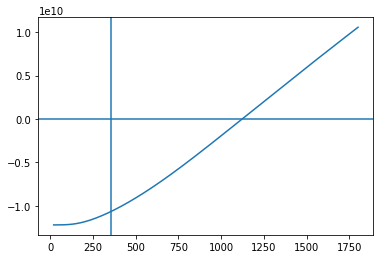

In [16]:
_, _, _, pmin, _, _ = french.french(0.1, 500, model='PBE', gibbs=True)
plt.plot(np.linspace(20, 1800, 1000), french.french(0.8, np.linspace(20, 1800, 1000), model='PBE', gibbs=True)[3]*1e9)
plt.axvline(353.5)
plt.axhline(2.2e6)

In [17]:
T_interp = np.linspace(np.min(T), 1800, 480)
p_interp = np.linspace(1.7e9, 1e12, 3000)
x, y = np.meshgrid(p_interp, T_interp)

# rho=1.39 corresponds to p=1.85Gpa at 500K
_, _, _, pmin, _, _ = french.french(1.39, T_interp, model='PBE', gibbs=True)
pmin *= 1e9

mask = np.ones_like(x)
for i, (xi, pi) in enumerate(zip(x, pmin)):
    mask[i][np.where(xi < pi)] = np.nan

g_interp = bisplev(p_interp, T_interp, tck_g).T
cv_interp = bisplev(p_interp, T_interp, tck_cv).T
rho_interp = bisplev(p_interp, T_interp, tck_rho).T

dT = np.diff(g_interp, axis=0) / np.diff(y, axis=0)
d2T = np.diff(dT, axis=0) / np.diff(y[1:], axis=0)
cp = -d2T * y[1:-1]

bmask = np.copy(mask)
bmask[np.isnan(mask)] = 0.0
bmask = np.bool8(mask)
g_interp[~bmask] = np.nan
rho_interp[~bmask] = np.nan
cv_interp[~bmask] = np.nan
cp[~bmask[1:-1,:]] = np.nan

savemat('french_gibbs.mat', {"pvec":p_interp[1:-1], 
                             "Tvec":T_interp[1:-1], 
                             "rho":rho_interp[1:-1,1:-1],
                             "G":g_interp[1:-1,1:-1], 
                             "Cv":cv_interp[1:-1,1:-1], 
                             "Cp":cp[:,1:-1], 
                             "nT":len(T_interp)-2, 
                             "nP":len(p_interp)-2,
                             "mask":mask[1:-1,1:-1]
                            })

#x, y = np.meshgrid(p_interp, T_interp)

#fig = plt.figure(figsize =(14, 9))
#ax = plt.axes(projection ='3d')
#ax.scatter(x.flatten(), y.flatten(), g_interp.flatten(), c=g_interp.flatten(), alpha=0.1)
#ax.scatter(p, T, g, 'o', c='k', s=20, alpha=1)

/Users/tgordon/research/rotation/french.py:70: RuntimeWarning: overflow encountered in square
  cv += np.sum(gamma * rho**(k/3) * Tj * Tj * np.exp(Tj/T) / (T * T * (np.exp(Tj/T) - 1)**2))


In [9]:
mask

array([[ 1.,  1.,  1., ...,  1.,  1.,  1.],
       [ 1.,  1.,  1., ...,  1.,  1.,  1.],
       [ 1.,  1.,  1., ...,  1.,  1.,  1.],
       ...,
       [nan, nan, nan, ...,  1.,  1.,  1.],
       [nan, nan, nan, ...,  1.,  1.,  1.],
       [nan, nan, nan, ...,  1.,  1.,  1.]])

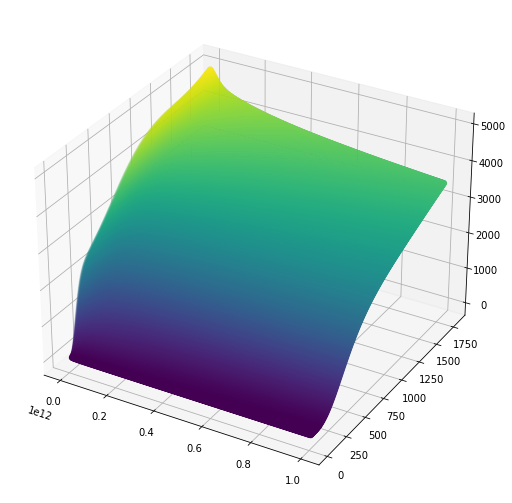

In [10]:
x, y = np.meshgrid(p_interp, T_interp)

fig = plt.figure(figsize =(14, 9))
ax = plt.axes(projection ='3d')
ax.scatter(x[1:-1,1:-1].flatten(), y[1:-1,1:-1].flatten(), cv_interp[1:-1,1:-1].flatten(), c=cv_interp[1:-1,1:-1].flatten(), alpha=0.1)

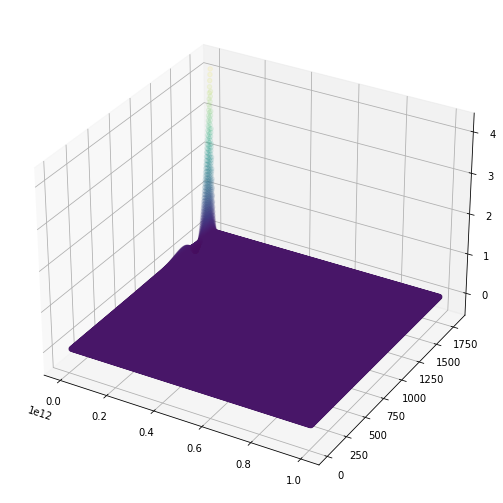

In [29]:
fig = plt.figure(figsize =(14, 9))
ax = plt.axes(projection ='3d')
ax.scatter(x[1:-1,1:-1].flatten(), y[1:-1,1:-1].flatten(), cp[:,1:-1].flatten(), c=cp[:,1:-1].flatten(), alpha=0.1)

In [256]:
#plt.imshow(cp[:,1:-1])
np.sum(np.isnan(mask))

5486

In [264]:
mask[np.isnan(mask)] = 0
np.bool8(mask)

array([[ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       ...,
       [False, False, False, ...,  True,  True,  True],
       [False, False, False, ...,  True,  True,  True],
       [False, False, False, ...,  True,  True,  True]])

In [34]:
1200**2/3000

480.0